In [3]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experiment

### load data

In [4]:
# x_all : Count matrix data from batch A (cells × genes)
# layers : Liver layer annotations for each sample
# time : Circadian clock time annotations for each sample

In [5]:
print(x_all.shape)
print(len(layers))      

(6889, 14812)
6889


### Preprocess data

In [13]:
import scanpy as sc
adata = sc.AnnData(x_all.tocsr())

sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)
sc.pp.scale(adata)

data = adata.X[:,np.where(adata.var['highly_variable'])[0]]

                            


In [14]:
x_all.shape

(6889, 14812)

In [15]:
data.shape

(6889, 2000)

# Choose SVD/PCA dim

In [32]:
from FP import *
x_SVD= SVD_mean_shifted(data,500)
x= (x[0][:,:20])* (x[1][None,:20])

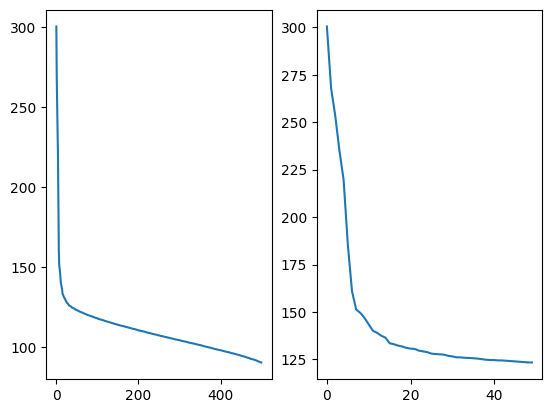

In [34]:
f,ax= plt.subplots(1,2)
ax[0].plot(x_SVD[1])
ax[1].plot(x_SVD[1][:50])

# FP

In [18]:
x.shape

(6889, 20)

In [ ]:
K=2
perplexity=40

FP_K2 = FP(K=K, perplexity=perplexity)

FP_K2.fit(x, verbose_updates= True,  simulations=100)


Begin sim 0
Current delta = 2.8249085617645178  amount 1/2 20 amount 01   0
Current delta = 2.8249085617645178  amount 1/2 20 amount 01   0
Current delta = 2.8249085617645178  amount 1/2 20 amount 01   0
Current delta = 2.8249085617645178  amount 1/2 20 amount 01   0
Current delta = 2.8249085617645178  amount 1/2 20 amount 01   0
Current delta = 1.4124542808822589  amount 1/2 20 amount 01   0
Current delta = 0.7062271404411294  amount 1/2 20 amount 01   0
Current delta = 0.3531135702205647  amount 1/2 20 amount 01   0
Current delta = 0.3531135702205647  amount 1/2 19 amount 01   0
Current delta = 0.3531135702205647  amount 1/2 18 amount 01   1
Current delta = 0.3531135702205647  amount 1/2 16 amount 01   2
Current delta = 0.3531135702205647  amount 1/2 15 amount 01   4
Current delta = 0.3531135702205647  amount 1/2 14 amount 01   5
Current delta = 0.3531135702205647  amount 1/2 11 amount 01   6
Current delta = 0.3531135702205647  amount 1/2 7 amount 01   9
Current delta = 0.35311357022

In [21]:
print(FP_K2.get_optimization_summary()['simulation_id'])

53

In [133]:
print(FP_K2.get_optimization_summary()['objective_value'])

np.float64(27.99619545101145)

### Visualizations

In [ ]:
feat_partitions = FP_K2.get_feature_partitions()

In [22]:
from sklearn.manifold import TSNE

emb_all = TSNE(n_components=2, random_state=42,perplexity=40).fit_transform( x)

emb_ours=[]
for i in range(K):
    tsne = TSNE(n_components=2, random_state=42,perplexity=40)
    emb_FP.append( tsne.fit_transform( x[:, feat_partitions[i]])   )

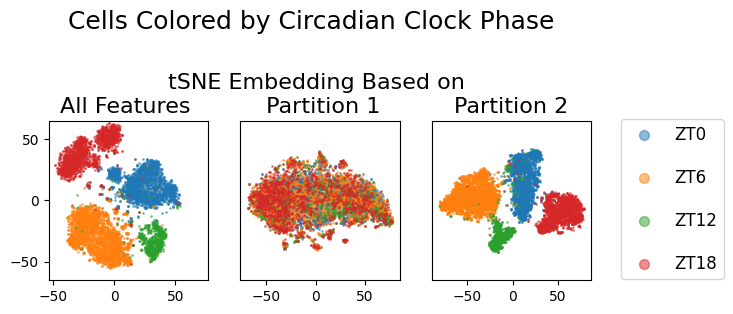

In [16]:
f,ax= plt.subplots(1,3,figsize=(7,3.5))

for i,lab in enumerate(np.unique(times)):
    label= str(['ZT0', 'ZT6','ZT12', 'ZT18'][i])
    inds= np.where(times==lab)[0]
    ax[0].scatter(emb_all[inds,0],emb_all[inds,1],alpha=0.5,label= label,s=1)
    
    ax[1].scatter(emb_FP[0][inds,0],emb_FP[0][inds,1],alpha=0.5,label= lab,s=1)

    ax[2].scatter(emb_FP[1][inds,0],emb_FP[1][inds,1],alpha=0.5,label= lab,s=1)

leg = f.legend(handles= ax[0].get_legend_handles_labels()[0],loc="center left", bbox_to_anchor=(.93, 0.5), fontsize=12, labelspacing=1.5)
for handle in leg.legend_handles:
    handle.set_sizes([50.0])

ax[0].set_title('All Features ',fontsize=16)
ax[1].set_title('tSNE Embedding Based on \n Partition 1',fontsize=16)
ax[2].set_title('Partition 2',fontsize=16)
for cur_ax in ax.flatten():
    cur_ax.axis('square')#,adjustable='box')

for cur_ax in ax.flatten():
    ymin,ymax= cur_ax.get_ylim()
    cur_ax.set_ylim([0-(ymax-ymin)/2,(ymax-ymin)/2])

for i in range(1,3):  # 3 rows
    ax[i].tick_params(left=False, labelleft=False)


plt.suptitle('Cells Colored by Circadian Clock Phase', fontsize=18,y=1.04)

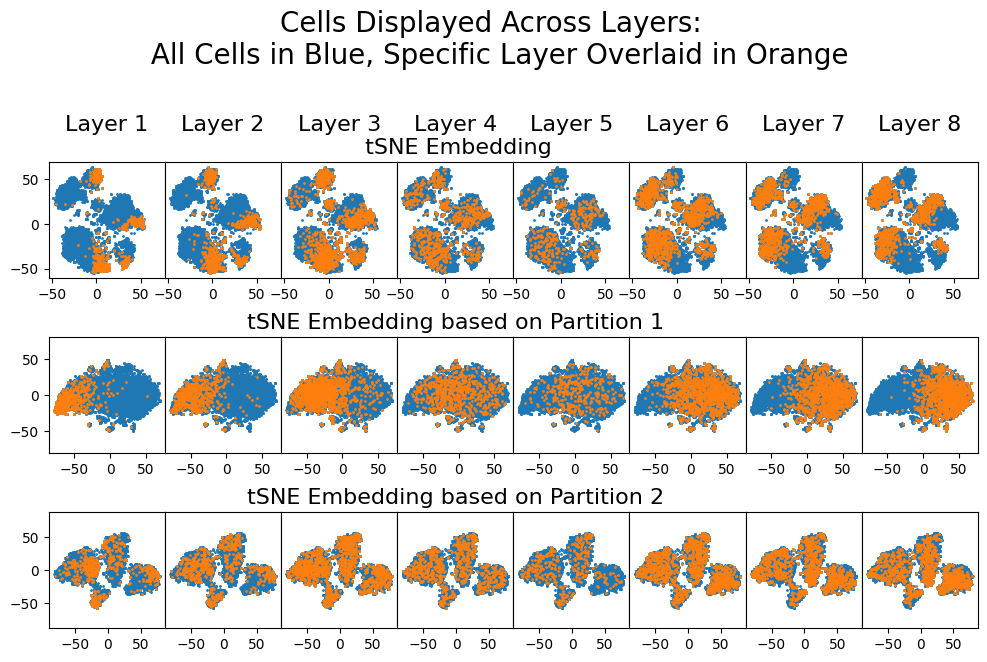

In [132]:
f,ax= plt.subplots(3,len((np.unique(layers))),figsize=(10,7))

for i,lab in enumerate(np.unique(layers)):
    inds= np.where(layers==lab)[0]

    ax[0,i].scatter(emb_all[:,0],emb_all[:,1],alpha=1,s=1)
    ax[0,i].scatter(emb_all[inds,0],emb_all[inds,1],alpha=1,label= label,s=1)
    
    ax[1,i].scatter(-emb_FP[0][:,0],emb_FP[0][:,1],alpha=1,label= lab,s=1)
    ax[1,i].scatter(-emb_FP[0][inds,0],emb_FP[0][inds,1],alpha=1,label= lab,s=1)

    ax[2,i].scatter(emb_FP[1][:,0],emb_FP[1][:,1],alpha=1,label= lab,s=1)
    ax[2,i].scatter(emb_FP[1][inds,0],emb_FP[1][inds,1],alpha=1,label= lab,s=1)

    if i!=3:
        ax[0,i].set_title('Layer '+str(lab)+'\n',fontsize=16)
    else:
        ax[0,i].set_title('Layer '+str(lab)+'\n tSNE Embedding',fontsize=16)

ax[1,3].set_title('tSNE Embedding based on Partition 1',fontsize=16)
ax[2,3].set_title('tSNE Embedding based on Partition 2',fontsize=16)

plt.suptitle("Cells Displayed Across Layers: \n All Cells in Blue, Specific Layer Overlaid in Orange",fontsize=20)
plt.tight_layout()
for cur_ax in ax.flatten():
    cur_ax.axis('square')#,adjustable='box')

for i in range(1,3):
    for j in range(len(np.unique(layers))):
        ymin,ymax= ax[i,j].get_ylim()

        ax[i,j].set_ylim([0-(ymax-ymin)/2,(ymax-ymin)/2])
    
for i in range(3):  # 3 rows
    for j in range(1,len((np.unique(layers)))):
        ax[i, j].tick_params(left=False, labelleft=False)


plt.subplots_adjust(wspace=0., hspace=.01)